In [398]:
%pwd

'c:\\'

In [399]:
%cd ../..

c:\


c:\Users\ASUS\.pyenv-win-venv\envs\antam_forecast_env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning:

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.



In [400]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tseries.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from tseries.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

from datetime import datetime
import locale


plt.rcParams['figure.figsize']=(30,20)
plt.rcParams['axes.labelsize']=20
plt.rcParams['axes.grid'] = False

Helper Functions

Unit Root Test Function

In [401]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

Stationary Technique Functions

In [402]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(12).mean().plot(ax=ax[v,r], legend=False)

Find Missing Dates Function

In [403]:
def missing_dates(timeseriesdata):
    """
    Find and print missing dates in a time series data after filling missing values.

    """
    # Generate a reference date range covering the entire period of your data
    start_date = timeseriesdata.index.min()
    end_date = timeseriesdata.index.max()
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Check for missing dates by comparing the reference date range with the actual dates in your data
    missing_dates = full_date_range[~full_date_range.isin(timeseriesdata.index)]

    # Print the missing dates, if any
    if len(missing_dates) == 0:
        print("No missing dates found.")
    else:
        print("Missing dates:")
        print(missing_dates)


Multiple Data Checker

In [404]:
def multiple_data(data, group_by_column='Date', count_column='Gold Price'):
    """
    Check for dates with multiple values in the specified count_column in the provided data.

    Parameters:
    - data: DataFrame, the data to be checked.
    - group_by_column: str, the column to group the data by specific column.
    - count_column: str, the column for which unique values are counted specific column.

    Returns:
    - None
    """
    # Group the data by the specified group_by_column and count the number of unique values in count_column for each group
    multiple_values = data.groupby(group_by_column)[count_column].nunique()

    # Filter groups where there are multiple values
    groups_with_multiple_values = multiple_values[multiple_values > 1]

    # Print the groups with multiple values
    if groups_with_multiple_values.empty:
        print(f"No {count_column}s with multiple values found.")
    else:
        print(f"{group_by_column}s with multiple {count_column}s:")
        print(groups_with_multiple_values)


# Loading Data
## Load all the data used in the analysis

In [405]:
data = pd.read_csv('C:/Users/ASUS/Documents/GitHub/antam-gold-forecasting/data/harga-emas-antam.csv')
data2 = data.copy()


In [406]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Timestamp   4295 non-null   object
 1   Date        4295 non-null   object
 2   Gold Price  4295 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.8+ KB


In [407]:
# Checking multiple data
multiple_data(data2,group_by_column='Date',count_column='Gold Price')

Dates with multiple Gold Prices:
Date
2010-05-07    2
2010-05-10    2
2010-06-03    2
2010-10-07    2
2010-12-01    2
2011-03-16    2
2011-08-05    2
2011-08-08    2
2011-08-09    3
2011-08-15    2
2011-08-18    2
2011-08-19    2
2011-09-13    2
2011-09-14    2
2011-11-11    2
2011-12-16    2
2012-02-03    2
2012-05-04    2
2012-05-10    2
2012-10-22    2
2012-11-07    2
2012-11-13    2
2013-08-28    2
2013-10-30    2
2014-01-02    2
2014-02-04    2
2015-02-11    2
2015-03-02    2
2015-03-26    2
2015-04-17    2
2015-05-13    2
2016-06-16    2
2016-06-24    2
2016-11-09    2
2017-10-03    2
2018-08-07    2
2018-11-15    2
2019-06-21    2
2020-02-24    2
2020-03-20    2
2020-03-23    2
2020-07-28    2
2020-09-01    2
2022-02-24    3
Name: Gold Price, dtype: int64


In [432]:
#Select only one value of these multiple data
# Convert 'Timestamp' to datetime if it's not already in datetime format
data2['Timestamp'] = pd.to_datetime(data2['Timestamp'])
data2['Date'] = pd.to_datetime(data2['Date'])

# Find the row with the latest timestamp for each date
latest_indices = data2.groupby('Date')['Timestamp'].idxmax()

# Select the rows corresponding to the latest timestamps and keep 'Date' and 'Gold Price' columns
latest_data = data2.loc[latest_indices, ['Date', 'Gold Price']]

# Drop duplicate rows
latest_data = latest_data.drop_duplicates(keep='first')

# Reset the index to make 'Date' a regular column again
latest_data.reset_index(drop=True, inplace=True)

# Checking multiple data
multiple_data(latest_data,group_by_column='Date',count_column='Gold Price')


No Gold Prices with multiple values found.


In [409]:
latest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        4191 non-null   datetime64[ns]
 1   Gold Price  4191 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 65.6 KB


In [410]:
# Set 'Date' column as index if it's not already in datetime format
daily = latest_data[~((latest_data['Date'].dt.year==2024)&(latest_data['Date'].dt.month==5))]
daily

,Date,Gold Price
0,2010-01-04,408000
1,2010-01-05,410000
2,2010-01-06,410000
3,2010-01-07,412000
4,2010-01-08,410000
...,...,...
4182,2024-04-26,1319000
4183,2024-04-27,1326000
4184,2024-04-28,1326000
4185,2024-04-29,1325000


In [411]:
#check missing dates
missing_dates(daily.set_index('Date'))

Missing dates:
DatetimeIndex(['2010-01-09', '2010-01-10', '2010-01-16', '2010-01-17',
               '2010-01-23', '2010-01-24', '2010-01-30', '2010-01-31',
               '2010-02-06', '2010-02-07',
               ...
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-07-01', '2023-12-30', '2023-12-31', '2024-01-01',
               '2024-04-10', '2024-04-11'],
              dtype='datetime64[ns]', length=1044, freq=None)


In [412]:
# Reindex the DataFrame to include all dates in the desired range
daily_full_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='D')
daily_reindexed = ts.reindex(ts_full_index)

# Fill missing values with the previous date's gold price value
daily = daily_reindexed.fillna(method='ffill')
# Reset the index and restore the 'Date' column
daily.reset_index(inplace=True)
daily.rename(columns={'index': 'Date'}, inplace=True)

# Print the DataFrame with missing dates filled
print("Gold prices with missing dates filled:")
daily

Gold prices with missing dates filled:


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\767686676.py:6: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Date,Gold Price
0,2010-01-04,408000.0
1,2010-01-05,410000.0
2,2010-01-06,410000.0
3,2010-01-07,412000.0
4,2010-01-08,410000.0
...,...,...
5226,2024-04-26,1319000.0
5227,2024-04-27,1326000.0
5228,2024-04-28,1326000.0
5229,2024-04-29,1325000.0


# Preview Data

In [413]:
daily.info()
daily.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 0 to 5230
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5231 non-null   datetime64[ns]
 1   Gold Price  5231 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 81.9 KB


,count,mean,min,25%,50%,75%,max,std
Date,5231,2017-03-02 23:59:59.999999744,2010-01-04 00:00:00,2013-08-03 12:00:00,2017-03-03 00:00:00,2020-09-30 12:00:00,2024-04-30 00:00:00,NaN
Gold Price,5231.0,705158.459186,394000.0,564000.0,617000.0,930000.0,1347000.0,207328.180877


## Visualize Data Trendline 

In [414]:
fig = px.line(daily, x='Date', y='Gold Price', title='Gold Price Time Series')
fig.update_xaxes(rangeslider_visible=True)

# Format y-axis ticks as currency
locale.setlocale(locale.LC_NUMERIC, 'id_ID')
fig.update_yaxes(tickprefix='Rp')

# Set the height and width of the chart
fig.update_layout(height=600, width=1000)

# Center-align the title
fig.update_layout(title_x=0.5)

fig.show()

# Checking Time Series Parameters

## Decompose Time Series

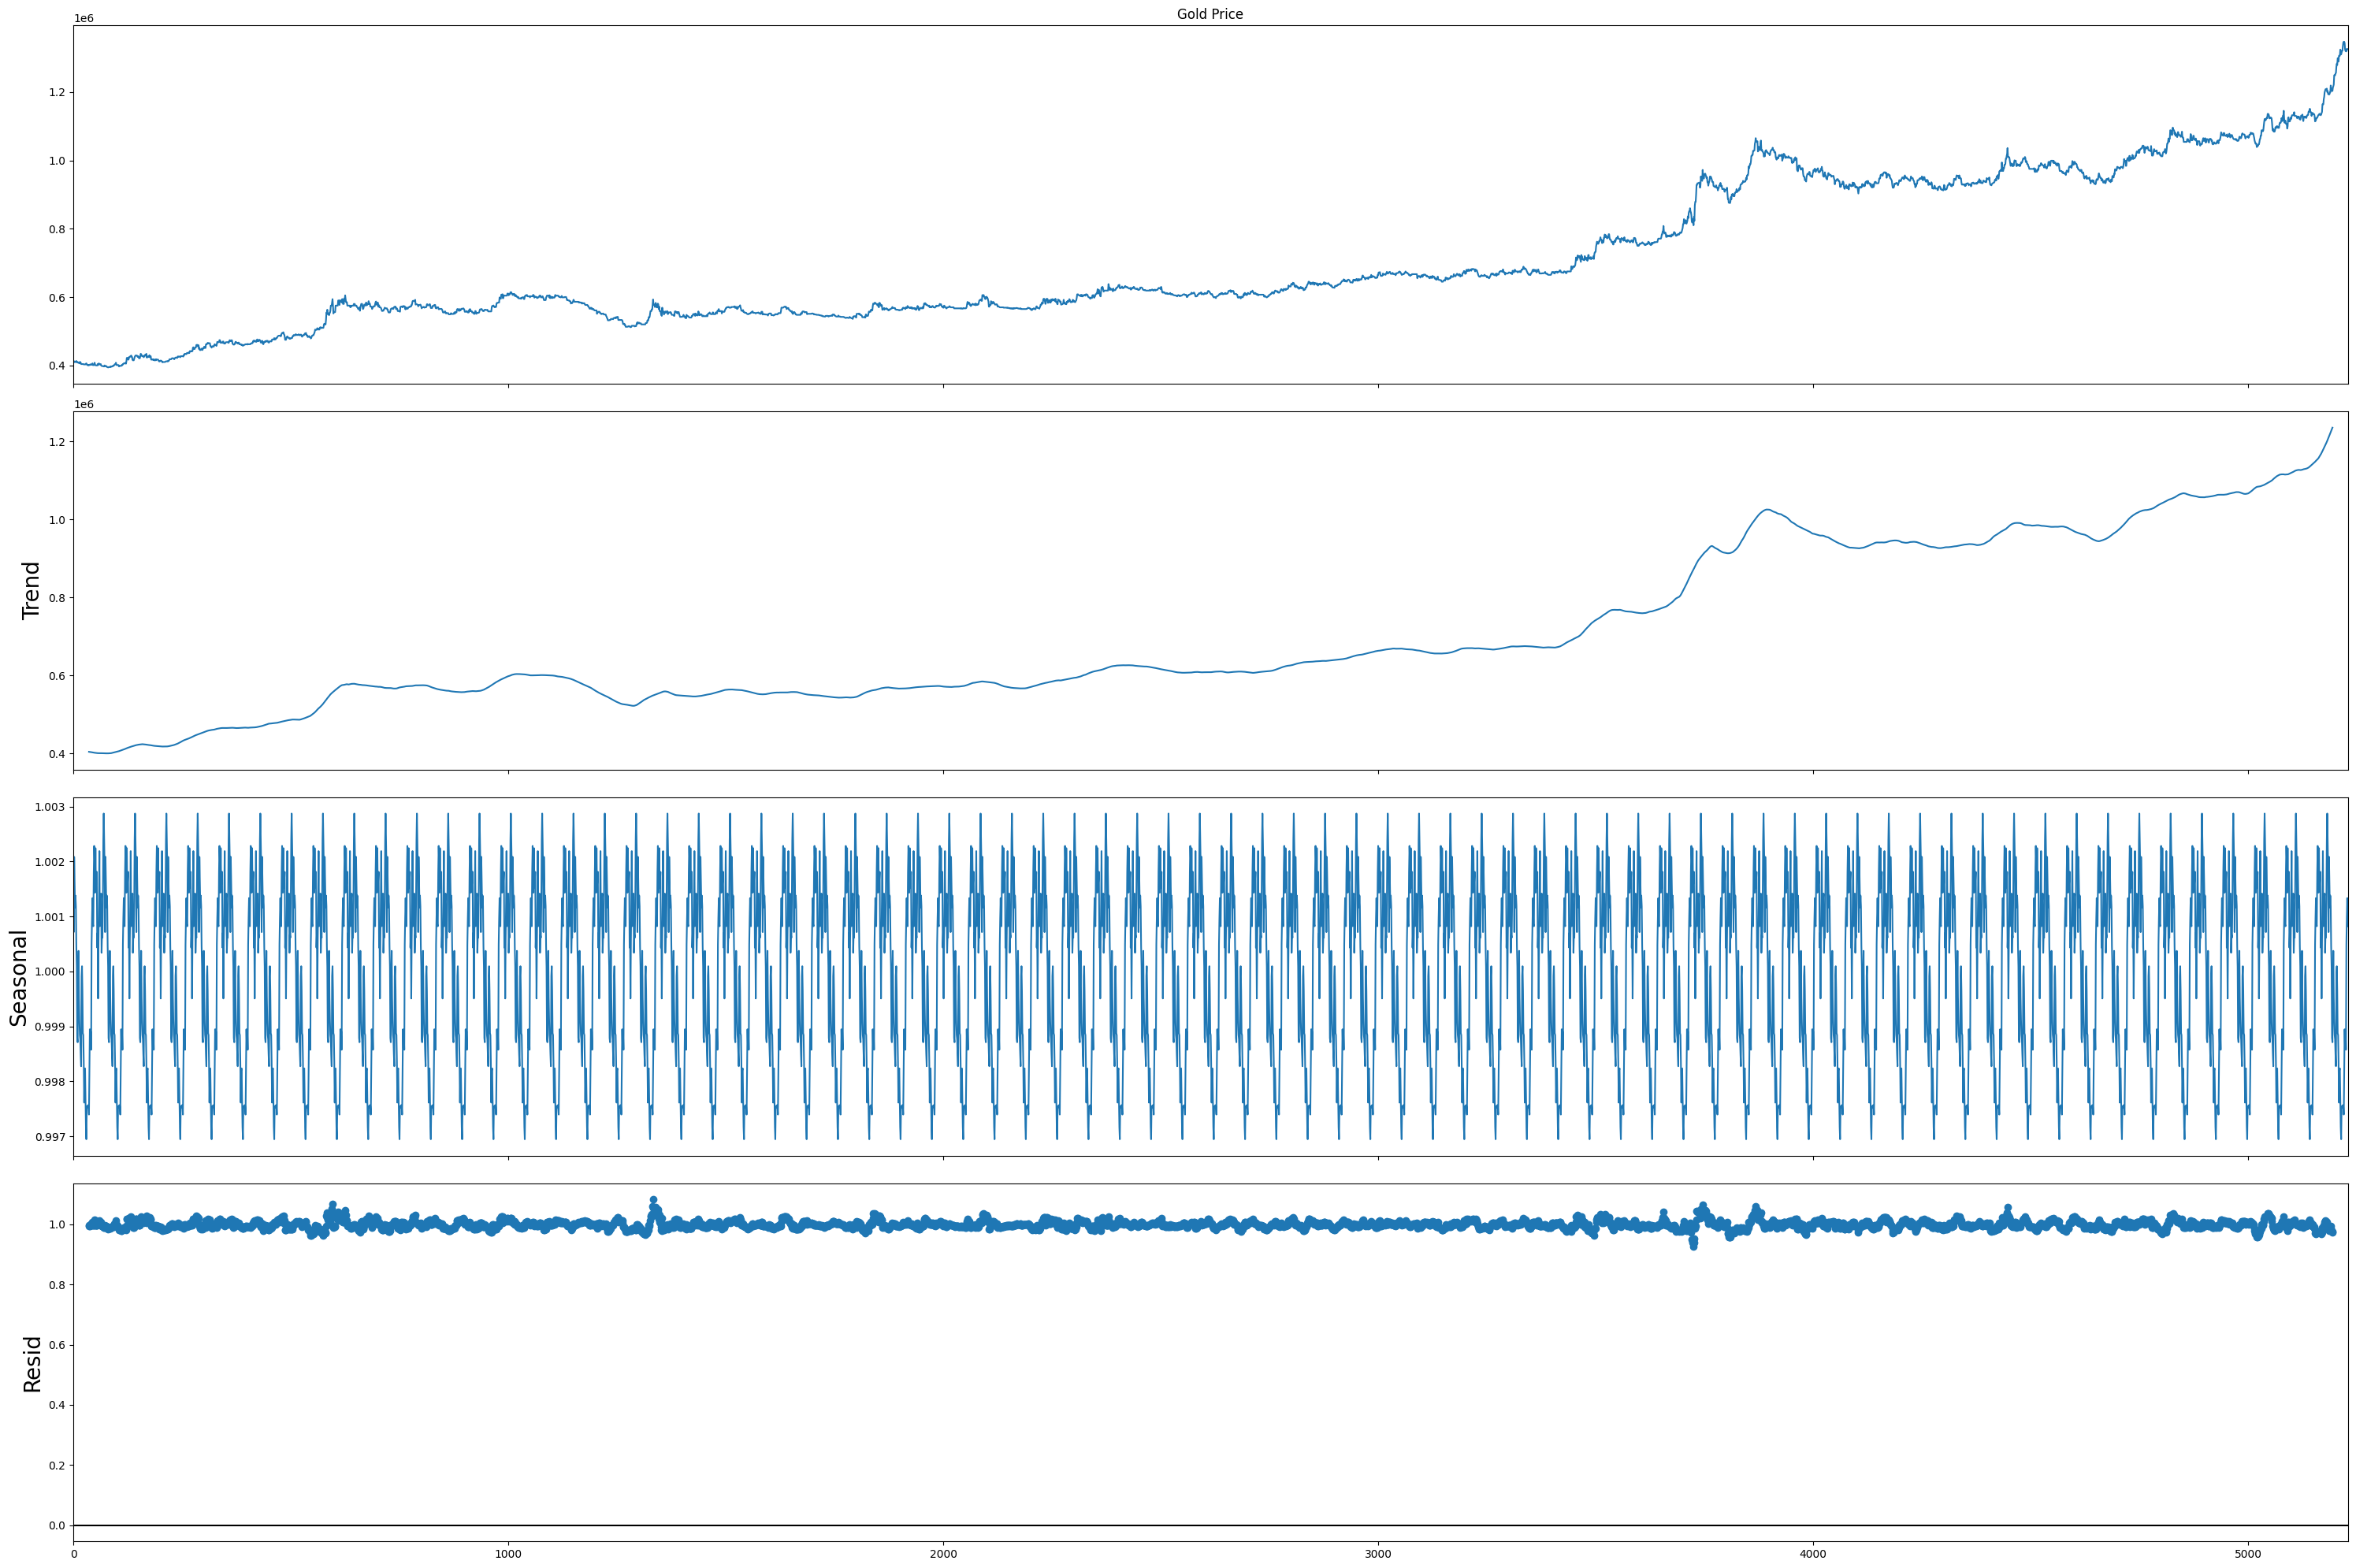

In [415]:
#Decompose
decomposition = seasonal_decompose(daily['Gold Price'], model='multiplicative', period=72)
decomposition.plot()
plt.show()

In [416]:
# lets create time series from goldprice 

timeSeries = daily.loc[:, ["Date","Gold Price"]]
timeSeries['Date'] = pd.to_datetime(timeSeries['Date'])  # Convert 'Date' column to datetime if it's not already
timeSeries.index = timeSeries['Date']
ts = timeSeries.drop("Date",axis=1)

# Now 'ts' should have a DateTimeIndex
ts.tail()

,Gold Price
Date,
2024-04-26,1319000.0
2024-04-27,1326000.0
2024-04-28,1326000.0
2024-04-29,1325000.0
2024-04-30,1325000.0


In [417]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5231 entries, 2010-01-04 to 2024-04-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gold Price  5231 non-null   float64
dtypes: float64(1)
memory usage: 81.7 KB


Stationarity Check

Detecting Unit Root: ADF & KPSS Test

In [418]:
adf_price_output = adfuller(ts)
kpss_price_output = kpss(ts)

pd.concat([
    unitroot_test_results(adf_price_output, 'adf'),
    unitroot_test_results(kpss_price_output, 'kpss')
], axis=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\3618356028.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,adf,kpss
Test Statistic,1.762581,10.49385
p-value,0.998272,0.01
Numbers of lags,2,43
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.431601,0.739
Critical Value (5%),-2.862093,0.463
Critical Value (10%),-2.567064,0.347
Critical Value (2.5%),NaN,0.574


Detecting Trend

In [419]:
kendall_tau_res = check_trend(ts, confidence=0.05)
mann_kendall_res = check_trend(ts, confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(ts, confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: increasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: True | Direction: increasing | Deterministic: False


Detrending & Deseasonalizing Techniques

AutoStationary

c:\Users\ASUS\Documents\GitHub\antam-gold-forecasting\tseries\transforms\target_transformations.py:545: UserWarning:

Trends with degree>1 are very strong and use with care.



Transformations applied: ['DetrendingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


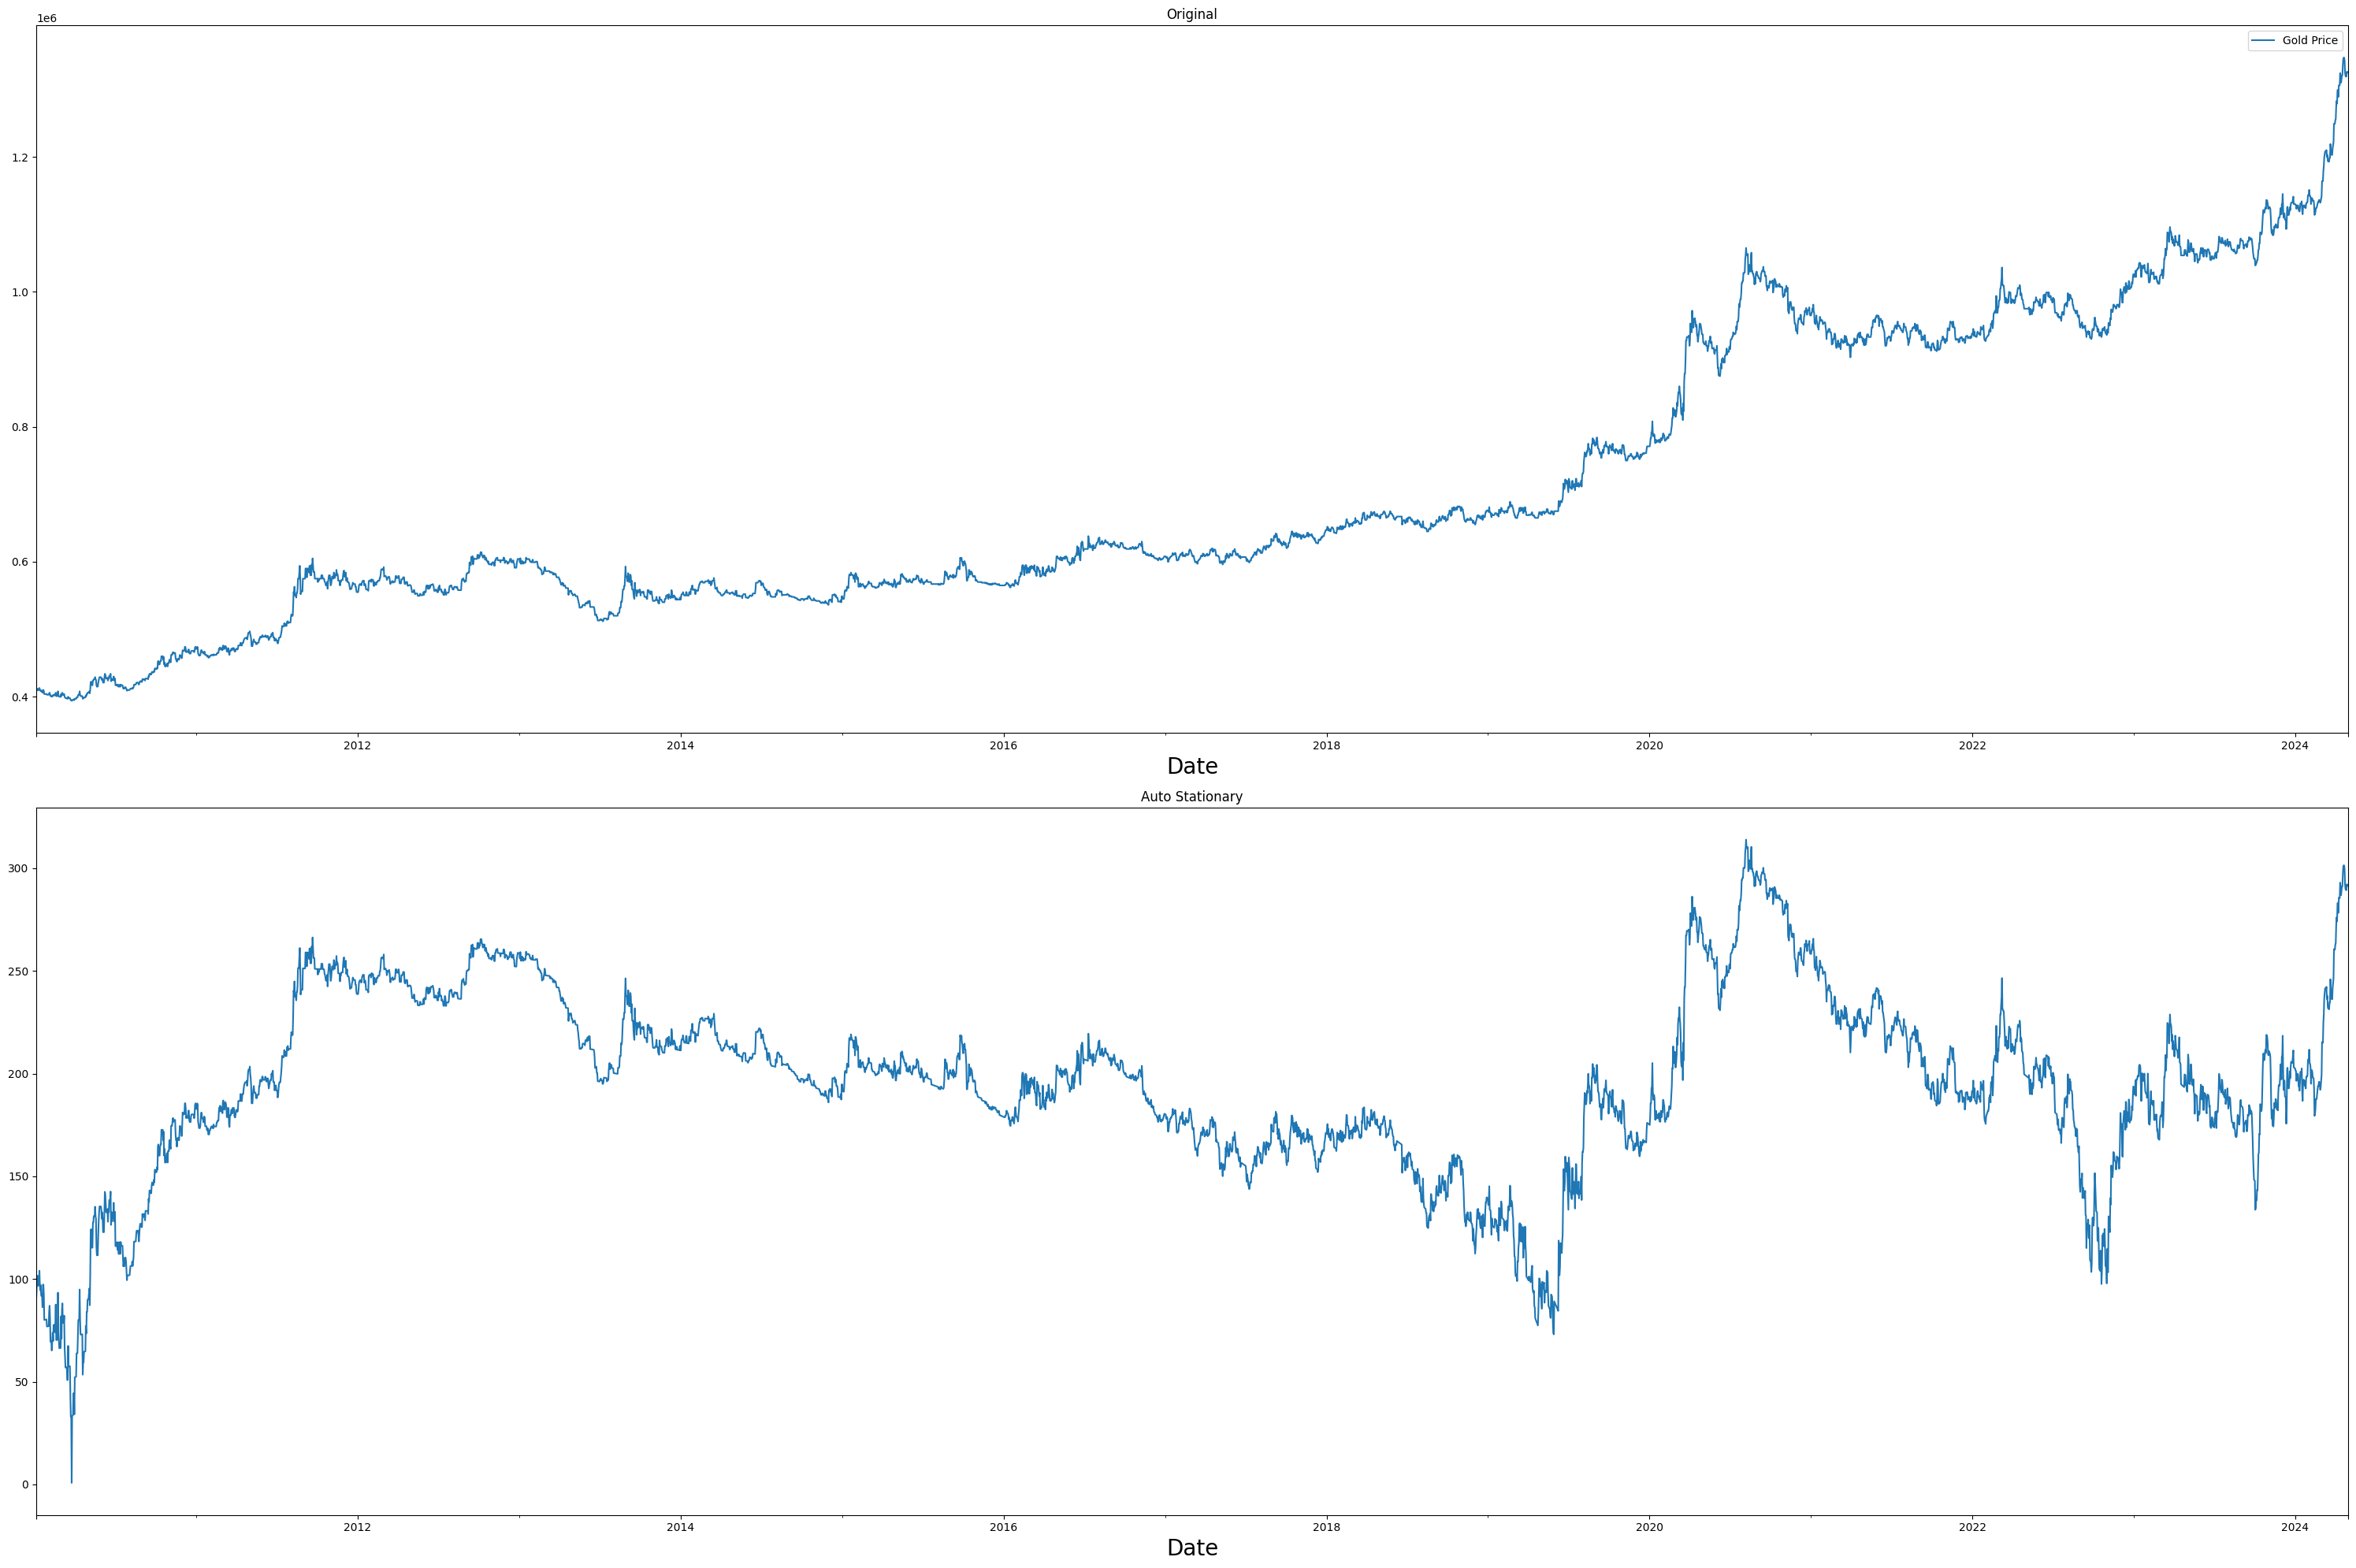

Unit Root: False with a p-value of 0.054931833940788266
Inverse == Original @ precision of 2 decimal points: True


In [420]:
# Set the frequency of the time series data to 'D'
ts.index.freq = 'D'

# Now proceed with the rest of your code
auto_stationary = AutoStationaryTransformer(seasonal_period=72, 
                                            detrender_params={'degree':2}, 
                                            trend_check_params={"mann_kendall":True})
y_stat = auto_stationary.fit_transform(ts,)
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

ts.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.05)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), index=ts.index, columns=["Gold Price"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==ts.round(3))}")

Other Techniques

Optimal Lambda: -0.6850073380888527


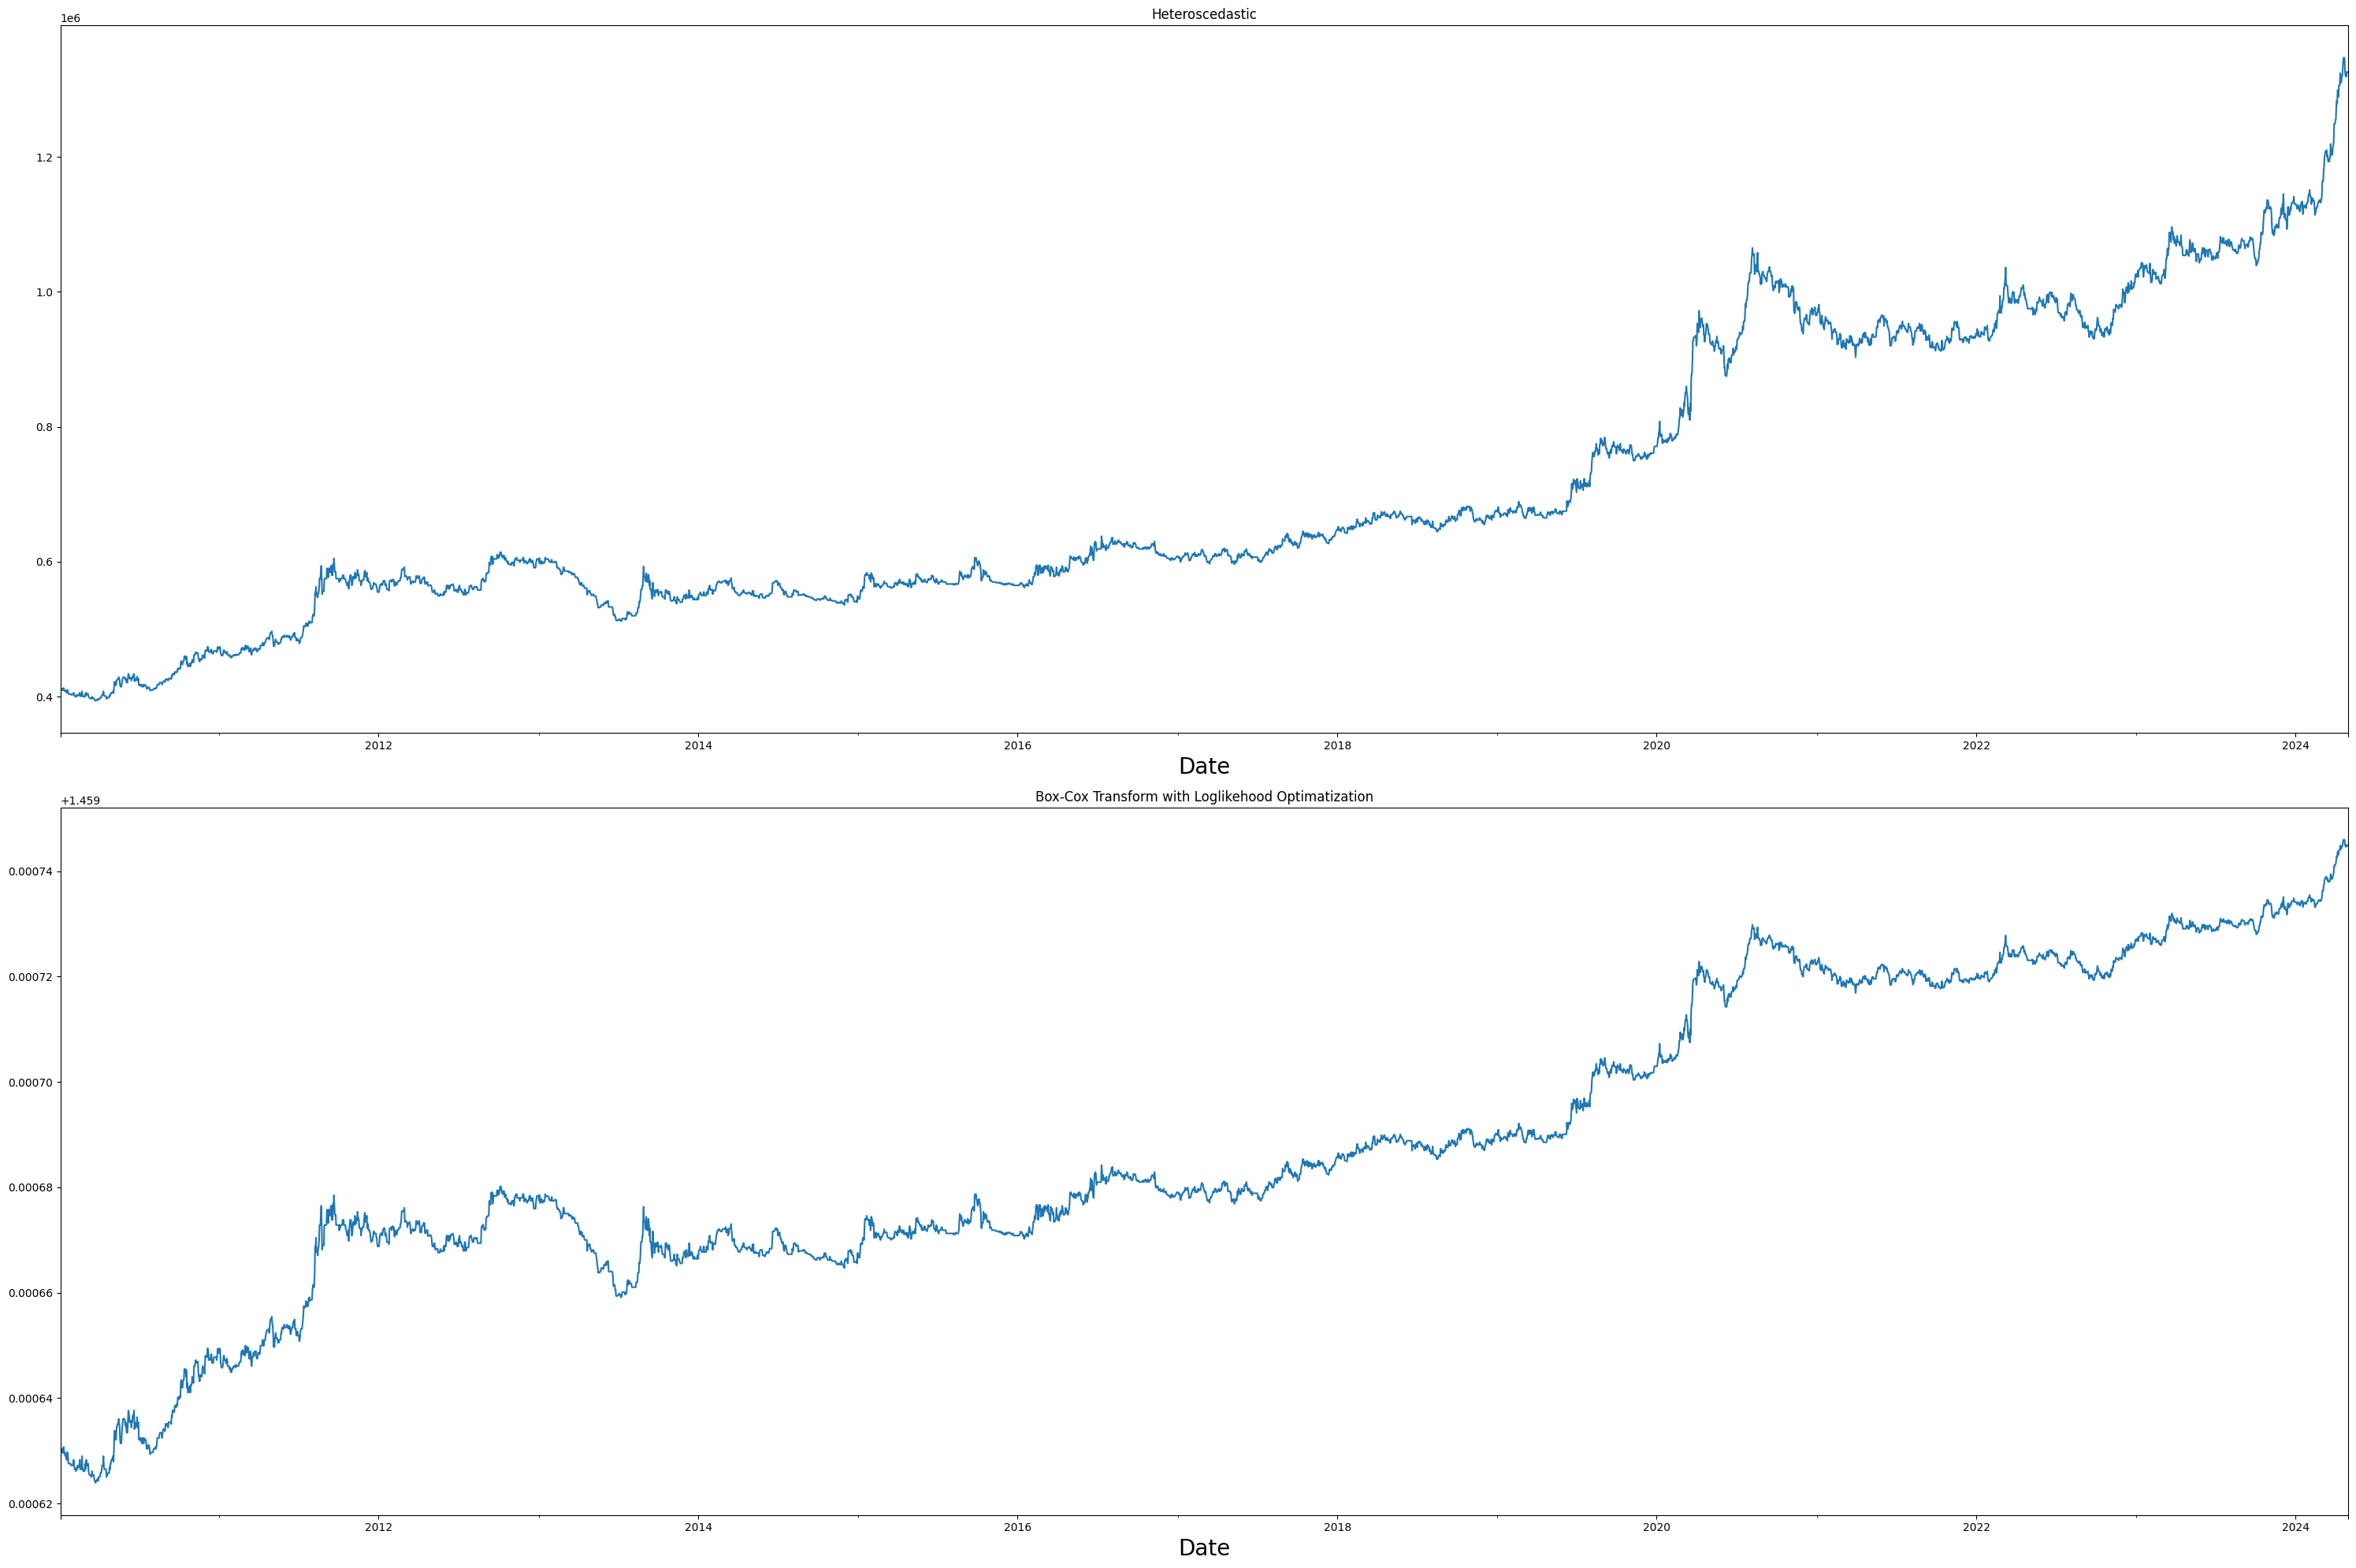

White Test for Heteroscedasticity: True with a p-value of 1.3977368952406506e-190


In [421]:
#shifting the series into positive domain
boxcox_transformer = BoxCoxTransformer(add_one=True, optimization="loglikelihood")
y_boxcox_loglikelihood = boxcox_transformer.fit_transform(ts["Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")

fig, axs = plt.subplots(2)
ts["Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_loglikelihood.plot(title="Box-Cox Transform with Loglikehood Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()

hetero_res = check_heteroscedastisticity(y_boxcox_loglikelihood, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

Optimal Lambda: -0.3722627183500376


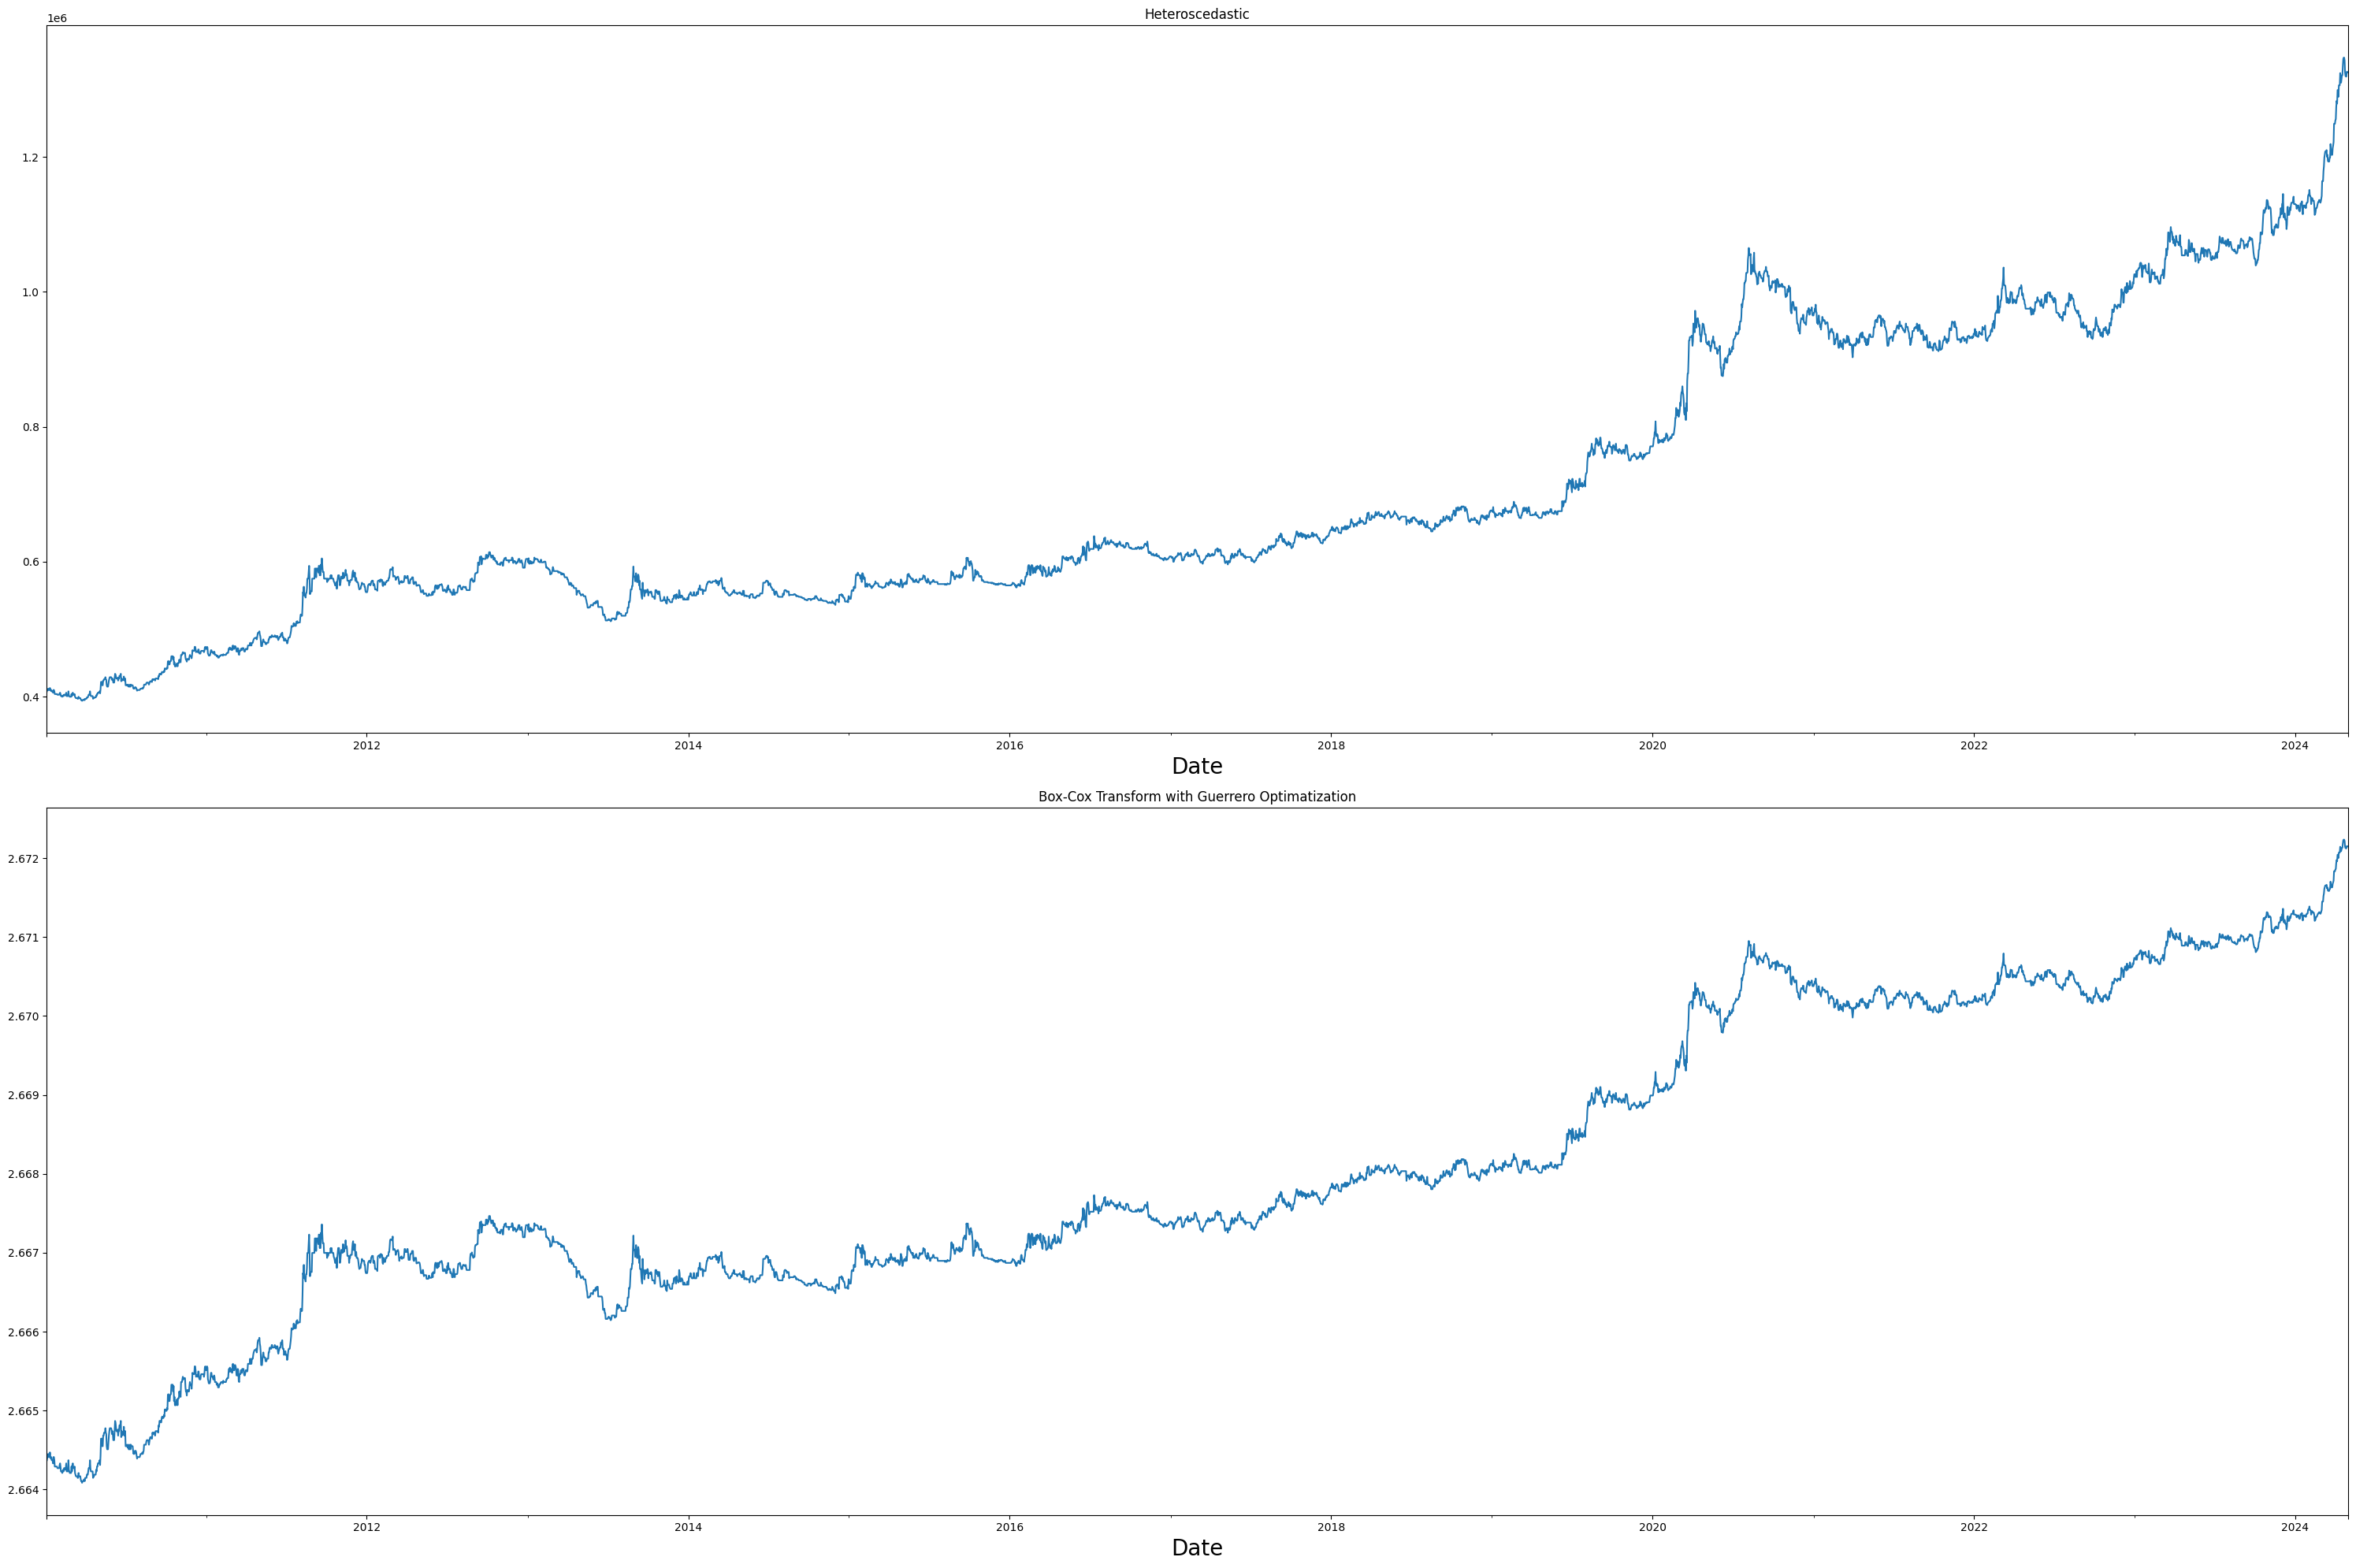

White Test for Heteroscedasticity: True with a p-value of 7.36142675140492e-79


In [422]:
#Arbritarily divided the data into sub-series of length 12
boxcox_transformer = BoxCoxTransformer(seasonal_period=72, add_one=True, optimization="guerrero")
y_boxcox_guerrero = boxcox_transformer.fit_transform(ts["Gold Price"])
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
ts["Gold Price"].plot(title="Heteroscedastic",ax=axs[0])
y_boxcox_guerrero.plot(title="Box-Cox Transform with Guerrero Optimatization",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox_guerrero, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\1990236185.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10916\1990236185.

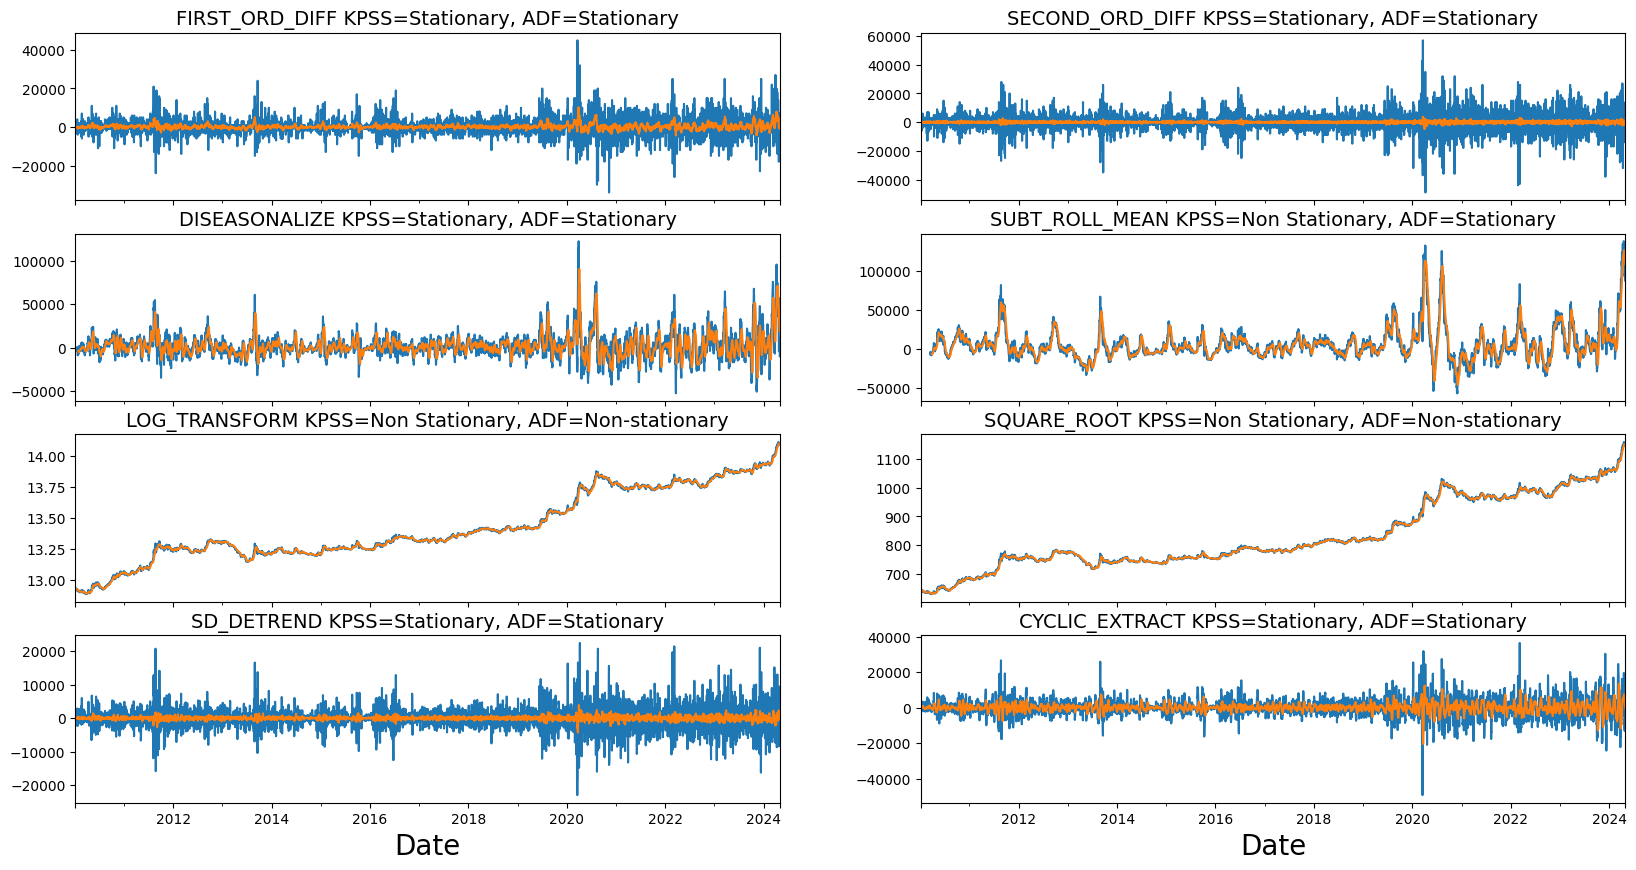

In [423]:
# using first order differencing (detrending)
first_ord_diff = ts.diff().dropna()

# using second order differencing
second_ord_diff = ts.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = ts.diff(12).dropna()

# using rolling mean 
rolling_mean = ts.rolling(window=72).mean()
subt_roll_mean = ts - rolling_mean

# log transform
log_transform = np.log(ts)

# Square root transform
square_root = np.sqrt(ts)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(ts)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(ts)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

plot = plot_comparison(methods)

Detecting Seasonality

Plotting ACF & PACF

Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)
Figure(3000x2000)


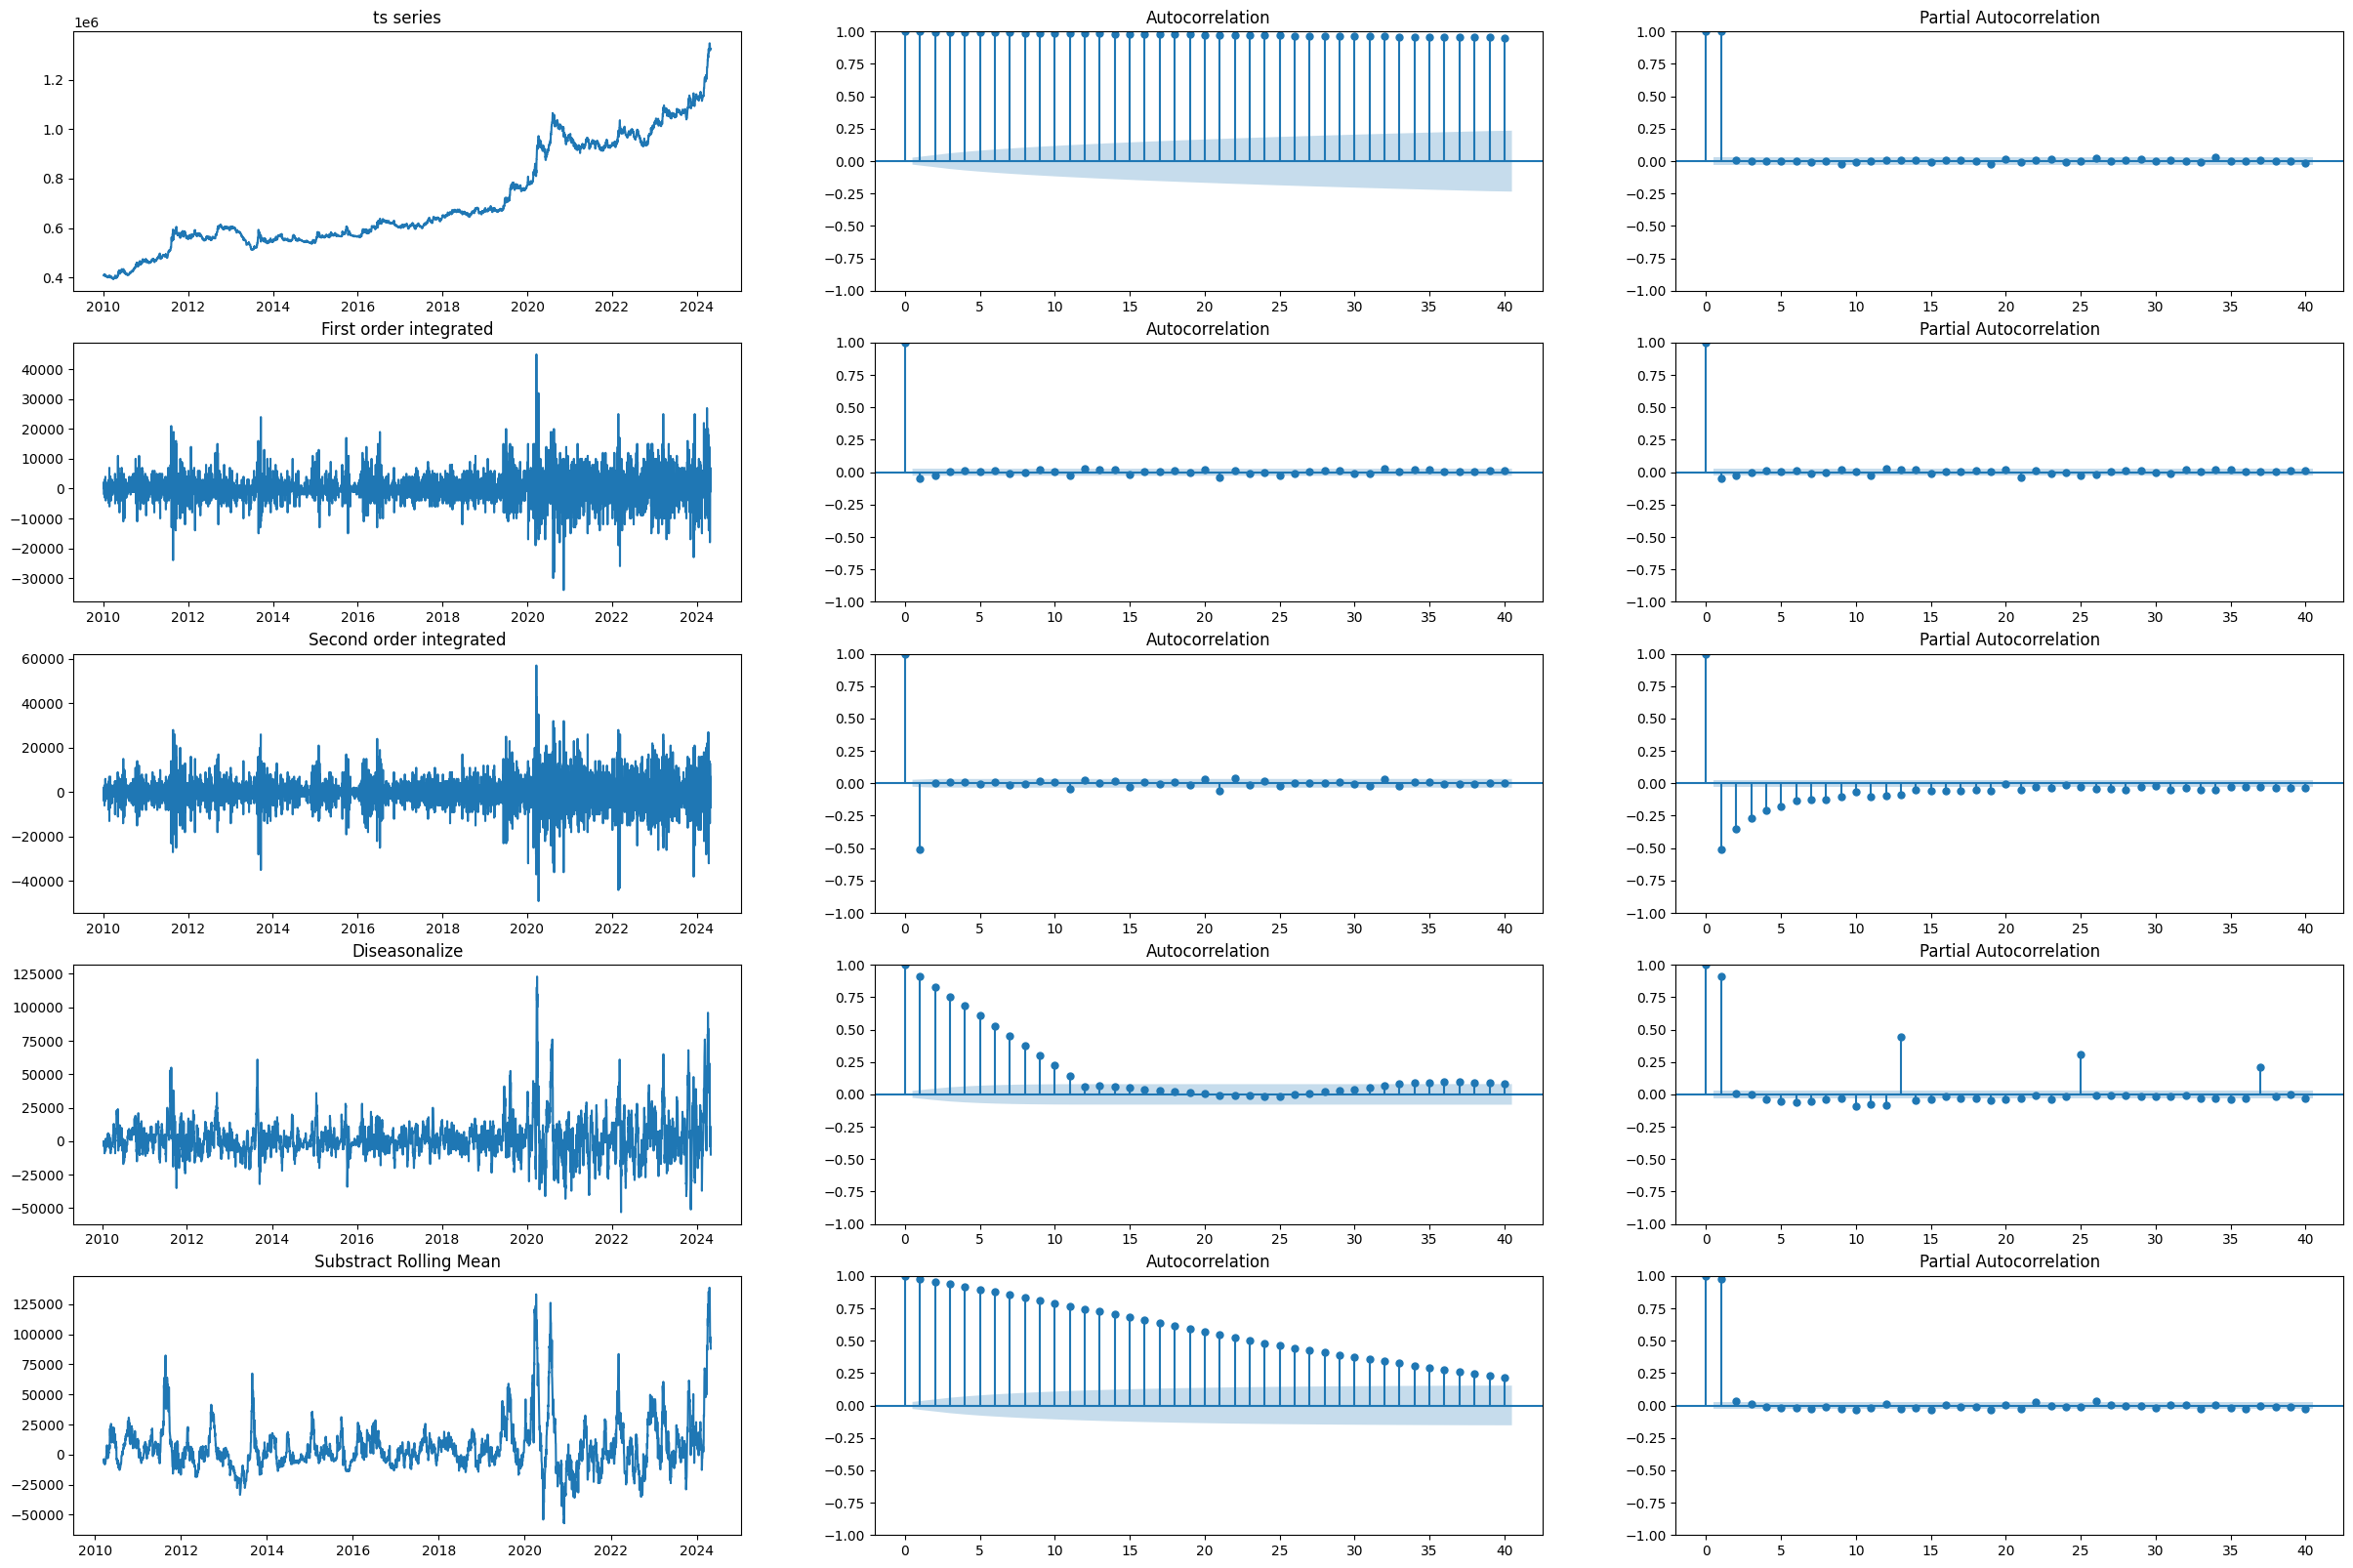

In [424]:
fig, axes = plt.subplots(5, 3, figsize=(30, 20))

# plot original series
axes[0,0].plot(ts)
axes[0,0].set_title("ts series")
print(plot_acf(ts, ax=axes[0,1], lags=40))
print(plot_pacf(ts, ax=axes[0,2], lags=40))

# plot first order integrated series
axes[1,0].plot(first_ord_diff)
axes[1,0].set_title("First order integrated")
print(plot_acf(first_ord_diff, ax=axes[1,1], lags=40))
print(plot_pacf(first_ord_diff, ax=axes[1,2], lags=40))

# plot first order integrated series
axes[2,0].plot(second_ord_diff)
axes[2,0].set_title("Second order integrated")
print(plot_acf(second_ord_diff, ax=axes[2,1], lags=40))
print(plot_pacf(second_ord_diff, ax=axes[2,2], lags=40))

# Deseasonalize series
axes[3,0].plot(diseasonalize)
axes[3,0].set_title("Diseasonalize")
print(plot_acf(diseasonalize, ax=axes[3,1], lags=40))
print(plot_pacf(diseasonalize, ax=axes[3,2], lags=40))

# Subtract Rolling Mean series
axes[4,0].plot(subt_roll_mean)
axes[4,0].set_title("Substract Rolling Mean")
print(plot_acf(subt_roll_mean, ax=axes[4,1], lags=40))
print(plot_pacf(subt_roll_mean, ax=axes[4,2], lags=40))

## Checking Stationarity

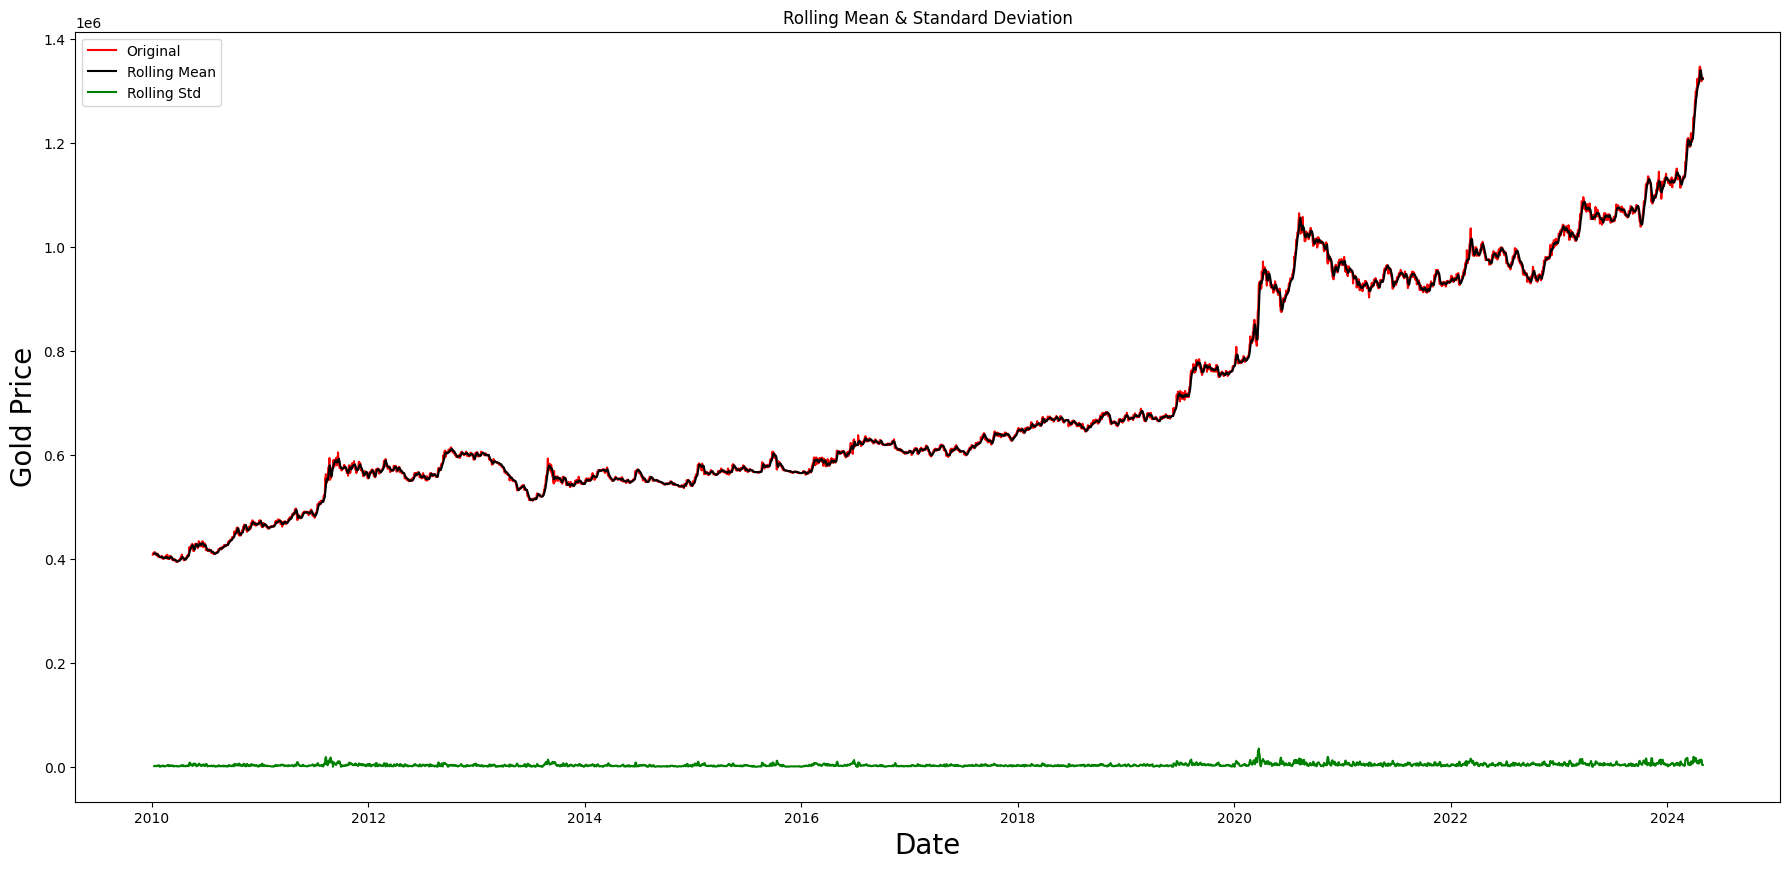

Test statistic:  1.7625810559184227
p-value:  0.9982718423367415
Critical Values: {'1%': -3.4316014372024277, '5%': -2.8620930052285543, '10%': -2.567064364441308}


In [425]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    # Rolling statistics
    rolmean = ts.rolling(window=6).mean()
    rolstd = ts.rolling(window=6).std()
    
    # Plotting
    plt.figure(figsize=(22, 10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Gold Price")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

# check stationary: mean, variance(std), and adfuller test
check_mean_std(ts)
check_adfuller(ts)


Our initial criterion for stationarity is a _constant mean_. However, our data fails this criterion as depicted by the non-constant mean evident from the plot (shown by the black line). Consequently, our data is deemed non-stationary.

The second criterion concerns constant variance, which appears to be satisfied in our case. Hence, our data meets this condition for stationarity.

Lastly, if the test statistic is lower than the critical value, we can conclude that the time series is stationary. Upon examination, we find that the test statistic is 1.2, whereas the critical values are as follows: {'1%', '5%', '10%'}. Since the test statistic exceeds the critical values, our time series is not stationary.

In summary, based on the above analyses, it is evident that our time series data is not stationary. Consequently, in the subsequent section, we will explore methods to transform the time series into a stationary form.

Detecting Statistically

In [426]:
def get_var_name(variable):
     for name, value in globals().items():
        if value is variable:
            return name
        
method_names = [get_var_name(method) for method in methods]

In [427]:
for method, method_name in zip(methods, method_names):
    seasonality_res = check_seasonality(method, max_lag=24, seasonal_period=12, confidence=0.05)
    print(f"Seasonality Test for 12th lag using {method_name}: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using first_ord_diff: True
Seasonality Test for 12th lag using second_ord_diff: True
Seasonality Test for 12th lag using diseasonalize: False
The ACF has no local maximum for m < max_lag = 24. Try larger max_lag
Seasonality Test for 12th lag using subt_roll_mean: False
The ACF has no local maximum for m < max_lag = 24. Try larger max_lag
Seasonality Test for 12th lag using log_transform: False
The ACF has no local maximum for m < max_lag = 24. Try larger max_lag
Seasonality Test for 12th lag using square_root: False
Seasonality Test for 12th lag using sd_detrend: False
Seasonality Test for 12th lag using cyclic_extract: False


Checking Normality

In [428]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [429]:
normal_args = (np.mean(ts),np.std(ts))

print(is_normal(shapiro(ts)))
print(is_normal(normaltest(ts)))
print(is_normal(normal_ad(ts)))
print(is_normal(kstest_normal(ts)))

Not Normal
Not Normal
Not Normal
Not Normal


c:\Users\ASUS\.pyenv-win-venv\envs\antam_forecast_env\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\ASUS\.pyenv-win-venv\envs\antam_forecast_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5231.



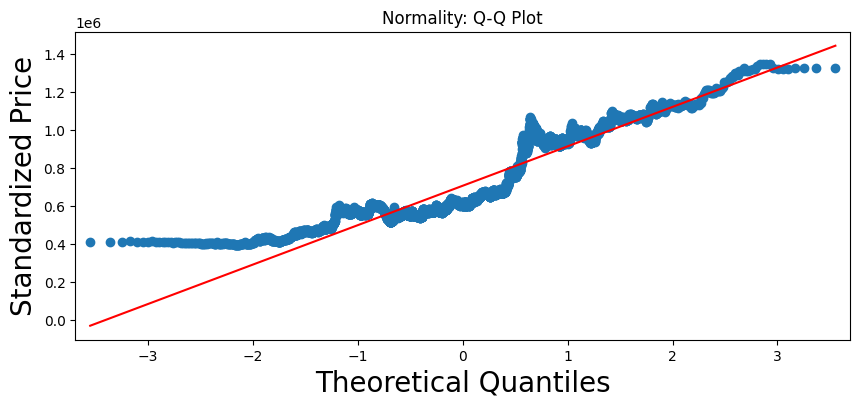

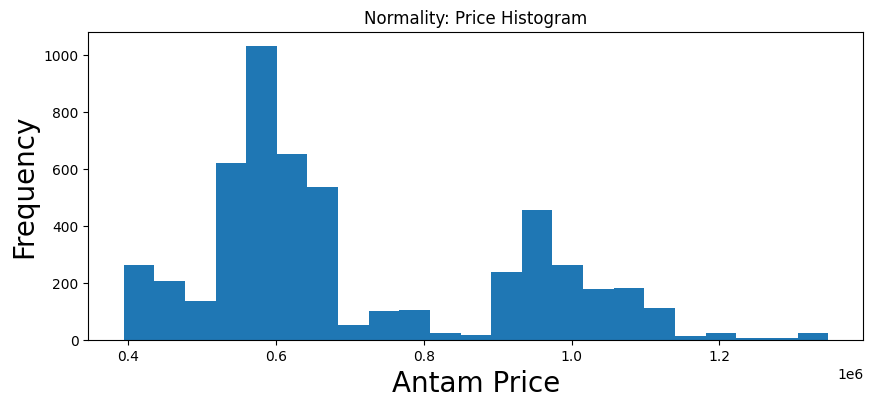

In [430]:
plt.rcParams["figure.figsize"] = [10, 4]

sm.qqplot(ts, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Price')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(ts, bins='auto')
plt.xlabel('Antam Price')
plt.ylabel('Frequency')
plt.title('Normality: Price Histogram')
plt.show()

Heteroskedactisity Test

In [431]:
for method, method_name in zip(methods, method_names):
    hetero_white_res = check_heteroscedastisticity(method, confidence=0.05)
    print(f"White Test for Heteroscedasticity on {method_name}: {hetero_white_res.heteroscedastic} with a p-value of {hetero_white_res.lm_p_value}")

White Test for Heteroscedasticity on first_ord_diff: True with a p-value of 9.948438082230691e-34
White Test for Heteroscedasticity on second_ord_diff: True with a p-value of 2.906862268307928e-35
White Test for Heteroscedasticity on diseasonalize: True with a p-value of 1.5296708189145214e-68
White Test for Heteroscedasticity on subt_roll_mean: True with a p-value of 8.895771781008437e-66
White Test for Heteroscedasticity on log_transform: True with a p-value of 2.5349266347612787e-20
White Test for Heteroscedasticity on square_root: True with a p-value of 6.5808562427361116e-24
White Test for Heteroscedasticity on sd_detrend: True with a p-value of 3.204219475356586e-51
White Test for Heteroscedasticity on cyclic_extract: True with a p-value of 1.9049765712516377e-58
